In [8]:
pip install pydotplus

**2.- Hacer un árbol de clasificación con la misma tabla que el problema 1. No olviden que tienen que hacer el ajuste de hiperparámetros.**

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np

In [10]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

In [11]:
#from chapter_8_utils import performance_evaluation_report

In [12]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

Tomaremos como base, la base final del ejercicio 1

In [13]:
df = pd.read_csv('/content/ini_final2 (3) (1).csv', index_col=0,na_values='')
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 35131 entries, 0.0 to 1013.1712259999999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   comp_interno2  35131 non-null  object 
 1   comp_interno4  35131 non-null  int64  
 2   categoria1     35131 non-null  int64  
 3   categoria3     35131 non-null  int64  
 4   comp_mixto1    35131 non-null  float64
 5   comp_externo1  35131 non-null  float64
 6   comp_externo2  35131 non-null  float64
 7   comp_externo3  35131 non-null  int64  
 8   Comp_final     35131 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.7+ MB


In [14]:
df.head()

,comp_interno2,comp_interno4,categoria1,categoria3,comp_mixto1,comp_externo1,comp_externo2,comp_externo3,Comp_final
comp_interno1,,,,,,,,,
0.000000,b'1',45,1,173,0.33334,40.579710,2.872738,62,1
0.000000,b'1',45,1,170,0.29186,-10.000000,-10.000000,119,1
0.000000,b'1',59,3,159,0.29112,349.275362,34.616490,94,1
2026.342452,b'1',67,2,146,0.27318,276.811594,27.434645,125,1
3546.099291,b'1',70,1,160,0.32988,640.579710,63.487504,81,1


Después de una serie de intentos, optamos por escoger los siguientes componentes, pues nos dieron el modelo más óptimo y además fueron las que a nuestro criterio, resultaban mejor para la base.


In [15]:
X = df[['comp_interno2','categoria3','comp_interno4','categoria1','comp_mixto1','comp_externo2','comp_externo3','Comp_final']]
y = X.pop('Comp_final')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.30,stratify=y)

In [17]:
X_train

,comp_interno2,categoria3,comp_interno4,categoria1,comp_mixto1,comp_externo2,comp_externo3
comp_interno1,,,,,,,
0.000000,b'0',176,50,1,0.35924,41.855789,118
0.000000,b'0',159,48,3,0.36000,11.634588,13
0.000000,b'1',146,52,3,0.36814,7.497845,117
0.000000,b'1',160,59,1,0.33300,3.332376,72
1215.805471,b'0',167,49,2,0.37000,22.120080,63
...,...,...,...,...,...,...,...
0.000000,b'1',147,38,2,0.38000,-10.000000,92
1418.439716,b'1',156,67,2,0.32642,3.447285,128
0.000000,b'1',169,41,1,0.34444,3.016375,51


In [18]:
num_features = X_train.select_dtypes(include='number').columns.to_list()

In [19]:
num_features

['categoria3',
 'comp_interno4',
 'categoria1',
 'comp_mixto1',
 'comp_externo2',
 'comp_externo3']

In [20]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()

In [21]:
cat_features

['comp_interno2']

In [22]:
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [23]:
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

In [24]:
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, sparse=False,
                                        handle_unknown='error', drop='first'))])

In [25]:
preprocessor = ColumnTransformer(transformers=[
               ('numerical', num_pipeline, num_features),
               ('categorical', cat_pipeline, cat_features)],
               remainder='drop')
#El remainder=drop es para eliminar la columna que no se le aplicó ninguna transformación

In [26]:
dec_tree = DecisionTreeClassifier(random_state=42)

In [27]:
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', dec_tree)])

In [28]:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['categoria3',
                                                   'comp_interno4',
                                                   'categoria1', 'comp_mixto1',
                                                   'comp_externo2',
                                                   'comp_externo3']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                          

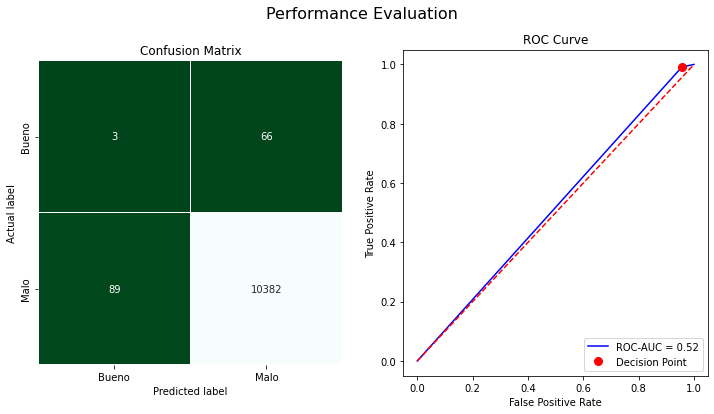

In [29]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(tree_pipeline, X_test,y_test, labels=LABELS,show_plot=True)

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

In [31]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [32]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())])

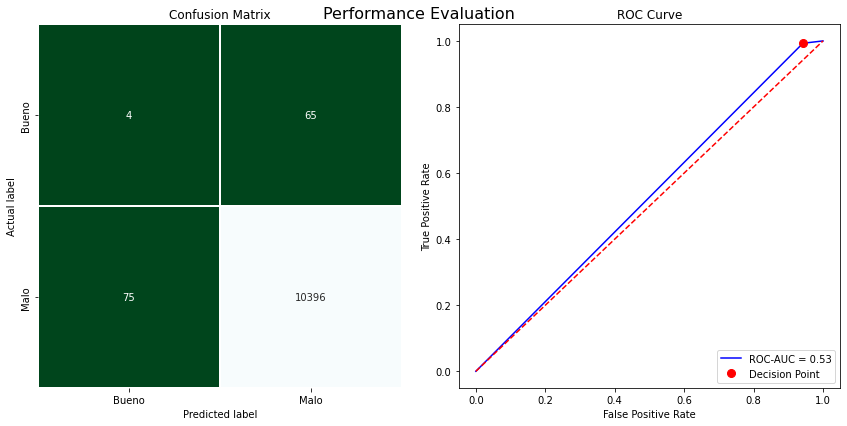

In [33]:
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],
                                 remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im18.png')
plt.show()

In [34]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)


Haremos la validación cruzada y esto nos ayudará a contestar el inciso 3), es decir, conocer los parámetros que se tomaron para hacer el árbol. 

In [35]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [36]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.98617605, 0.98312322, 0.98169988, 0.98434323, 0.98495323])

In [37]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

{'fit_time': array([0.10382724, 0.10209417, 0.107656  , 0.10201859, 0.10009933]),
 'score_time': array([0.03571773, 0.03512836, 0.03557611, 0.0383873 , 0.03472781]),
 'test_accuracy': array([0.98617605, 0.98312322, 0.98169988, 0.98434323, 0.98495323]),
 'test_precision': array([0.99384994, 0.99362795, 0.99341564, 0.9934332 , 0.9938411 ]),
 'test_recall': array([0.99222268, 0.98935735, 0.98812935, 0.99079001, 0.99099284]),
 'test_roc_auc': array([0.54156588, 0.51030367, 0.49406467, 0.49539501, 0.54095096])}

In [38]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 30),
               'classifier__min_samples_leaf': range(2, 30)}


Buscamos la mejor configuración para el modelo




In [39]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['categoria3',
                                                                          'comp_interno4',
                                                                          'categoria1',
                                                                          'c

In [40]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2}
Recall (Training set): 1.0000
Recall (Test set): 1.0000


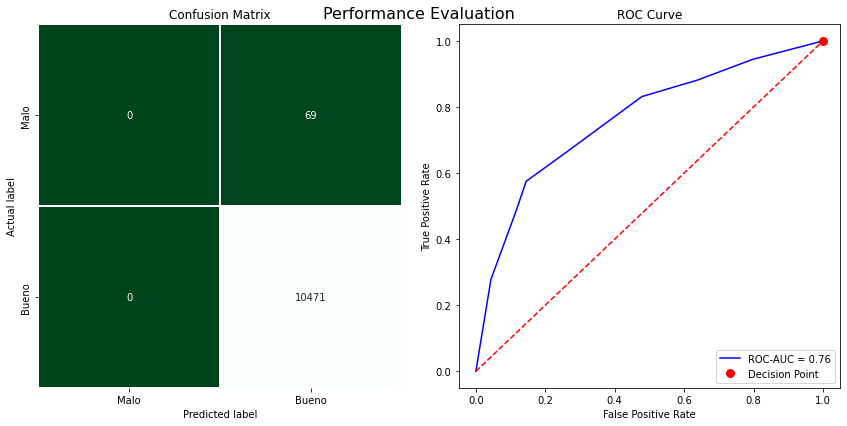

In [41]:
LABELS = ['Malo', 'Bueno']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score

En este caso cambiamos el criterio a entropy debido a un analisis posterior 

In [43]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in range(1, 27):
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeClassifier(criterion='entropy',
                                          max_depth=max_depth,
                                          min_samples_leaf=10,
                                          random_state=42)
    tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [],[], []
    for train_idx, test_idx in k_fold.split(X_train,y_train):
        X_t, y_t,  = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_te, y_te = X_train.iloc[test_idx], y_train.iloc[test_idx]
        tree_pipeline.fit(X_t, y_t)
        train_pred = tree_pipeline.predict_proba(X=X_t)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_t)
        #print(train_score)
        train_scores[max_depth].append(train_score)

        test_pred = tree_pipeline.predict_proba(X=X_te)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_te)
        val_scores[max_depth].append(val_score)  
        #print(val_score)
        leaves[max_depth].append(max_depth)
        #reg_tree.fit(X=X_t, y=y_t)

        
        #train_scores[max_depth].append(train_score)

        #test_pred = reg_tree.predict(X=X_test)
        #val_score = np.sqrt(mean_squared_error(
        #    y_pred=test_pred, y_true=y_test))
        #val_scores[max_depth].append(val_score)
        #leaves[max_depth].append(get_leaves_count(reg_tree))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [44]:
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
bd_leaves = pd.DataFrame(leaves)

In [45]:
leaves

{1: [1, 1, 1, 1, 1],
 2: [2, 2, 2, 2, 2],
 3: [3, 3, 3, 3, 3],
 4: [4, 4, 4, 4, 4],
 5: [5, 5, 5, 5, 5],
 6: [6, 6, 6, 6, 6],
 7: [7, 7, 7, 7, 7],
 8: [8, 8, 8, 8, 8],
 9: [9, 9, 9, 9, 9],
 10: [10, 10, 10, 10, 10],
 11: [11, 11, 11, 11, 11],
 12: [12, 12, 12, 12, 12],
 13: [13, 13, 13, 13, 13],
 14: [14, 14, 14, 14, 14],
 15: [15, 15, 15, 15, 15],
 16: [16, 16, 16, 16, 16],
 17: [17, 17, 17, 17, 17],
 18: [18, 18, 18, 18, 18],
 19: [19, 19, 19, 19, 19],
 20: [20, 20, 20, 20, 20],
 21: [21, 21, 21, 21, 21],
 22: [22, 22, 22, 22, 22],
 23: [23, 23, 23, 23, 23],
 24: [24, 24, 24, 24, 24],
 25: [25, 25, 25, 25, 25],
 26: [26, 26, 26, 26, 26]}

In [46]:
clf_train_scores

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.688296,0.767846,0.817692,0.848339,0.887799,0.920935,0.940414,0.958950,0.970379,0.978979,0.982642,0.985169,0.986019,0.986891,0.987518,0.987672,0.987965,0.988412,0.988441,0.988470,0.988470,0.988470,0.988470,0.988470,0.988470,0.988470
1,0.705387,0.762483,0.813278,0.841055,0.868649,0.892834,0.916930,0.939893,0.962731,0.971262,0.978628,0.983970,0.985502,0.986823,0.987142,0.987398,0.987442,0.987509,0.987509,0.987509,0.987509,0.987509,0.987509,0.987509,0.987509,0.987509
2,0.711884,0.780805,0.818520,0.848727,0.878069,0.903001,0.937401,0.957637,0.972135,0.980129,0.983396,0.985637,0.987550,0.988305,0.988613,0.988919,0.989108,0.989108,0.989108,0.989108,0.989108,0.989108,0.989108,0.989108,0.989108,0.989108
3,0.702497,0.770106,0.812523,0.849081,0.880956,0.912682,0.937486,0.955605,0.967243,0.974268,0.978434,0.981738,0.983840,0.985235,0.986939,0.987146,0.987356,0.987745,0.988047,0.988092,0.988175,0.988304,0.988462,0.988512,0.988512,0.988512
4,0.699237,0.772220,0.820116,0.850197,0.883703,0.917163,0.942860,0.958953,0.969344,0.976263,0.981310,0.984936,0.986461,0.987347,0.987904,0.988244,0.988334,0.988334,0.988334,0.988334,0.988334,0.988334,0.988334,0.988334,0.988334,0.988334


In [47]:
clf_valid_scores

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.672537,0.742468,0.744130,0.743190,0.708043,0.696498,0.648076,0.614973,0.621873,0.606461,0.610424,0.587197,0.588577,0.575305,0.576871,0.578918,0.580319,0.581293,0.555803,0.556100,0.556100,0.556100,0.556100,0.556100,0.556100,0.556100
1,0.699633,0.721999,0.751183,0.718030,0.736438,0.731020,0.655524,0.621546,0.546728,0.572794,0.561573,0.515657,0.519680,0.523057,0.524886,0.509728,0.525615,0.525321,0.525321,0.525321,0.525321,0.525321,0.525321,0.525321,0.525321,0.525321
2,0.638815,0.658418,0.707337,0.738104,0.726543,0.729153,0.682278,0.655821,0.561397,0.547751,0.543389,0.531602,0.553824,0.555423,0.556494,0.556507,0.556875,0.556875,0.556875,0.556875,0.556875,0.556875,0.556875,0.556875,0.556875,0.556875
3,0.691849,0.679902,0.721219,0.735328,0.653995,0.615905,0.612055,0.542324,0.507531,0.496706,0.499482,0.508785,0.514925,0.515922,0.520921,0.521180,0.520786,0.522293,0.509101,0.494560,0.494992,0.494813,0.495216,0.495315,0.495315,0.495315
4,0.629828,0.685277,0.723163,0.750926,0.736633,0.748317,0.655916,0.638978,0.606585,0.540752,0.508340,0.515809,0.511212,0.512376,0.500965,0.506299,0.506960,0.506960,0.506960,0.506960,0.506960,0.506960,0.506960,0.506960,0.506960,0.506960


In [48]:
roc_entrenamiento=[]
for c in clf_train_scores.columns:
    promedio_roc=mean(clf_train_scores[c])
    roc_entrenamiento.append(promedio_roc)
    
roc_validacion=[]
for c in clf_valid_scores.columns:
    promedio_roc=mean(clf_valid_scores[c])
    roc_validacion.append(promedio_roc)

prof=[]
for c in bd_leaves.columns:
    id_=mean(bd_leaves[c])
    prof.append(id_)

In [49]:
roc_entrenamiento

[0.7014601612208482,
 0.7706919560216481,
 0.8164257033785756,
 0.8474798231346187,
 0.8798353893966558,
 0.9093230423518474,
 0.935018259500195,
 0.9542075948624864,
 0.9683665581413374,
 0.9761804047541844,
 0.9808819940079936,
 0.9842898856176155,
 0.9858744964341509,
 0.9869202549542285,
 0.9876233264941614,
 0.9878756769616489,
 0.9880409910554017,
 0.9882212427829273,
 0.9882876117283572,
 0.9883023372952164,
 0.9883189082492075,
 0.9883447290231222,
 0.9883762571327346,
 0.9883862548104393,
 0.9883862548104393,
 0.9883862548104393]

In [50]:
roc_validacion

[0.6665324744660883,
 0.6976126383047073,
 0.7294063031118687,
 0.7371156488268429,
 0.7123306612334692,
 0.7041788080016822,
 0.6507698498375473,
 0.6147286643465492,
 0.5688226237584819,
 0.5528929104257255,
 0.5446415705110418,
 0.5318099329240983,
 0.5376436479120746,
 0.5364165499361688,
 0.5360273329886741,
 0.5345263737534195,
 0.5381111636930527,
 0.5385483086278695,
 0.5308119770869176,
 0.52796333486238,
 0.5280496784972553,
 0.528013861878344,
 0.5280944492708942,
 0.5281142763277915,
 0.5281142763277915,
 0.5281142763277915]

Vemos la grafica de validación

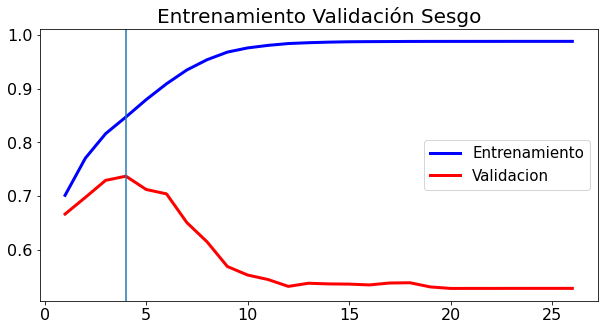

In [51]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Entrenamiento Validación Sesgo",fontsize=20)
ax.plot(prof,roc_entrenamiento,color="blue",linewidth=3,label="Entrenamiento")
ax.plot(prof,roc_validacion,color="red",linewidth=3,label="Validacion")
#gca().yaxis.set_major_formatter("{x:,.0%}")
xticks(fontsize=16)
yticks(fontsize=16)
axvline(4)
legend(fontsize=15)
show()

Obtenemos los valores para hacer la comparación de modelos

##KS

In [52]:
from scipy.stats import ks_2samp
y_pred = classifier_gs.predict(X_test)
Ks=ks_2samp(y_test,y_pred)
Ks

Ks_2sampResult(statistic=0.006546489563567362, pvalue=0.9776182955227385)

## Gini

In [53]:
gini=2*tree_gs_perf['roc_auc']-1
gini

0.5252284086206347

## Cross validate

Este dato se puede consultar mas arriba para tener mas detalles del mismo y no repetir una linea de ejecución.